## segmentation models pytorch
DeepLabV3Plus

参考: https://www.kaggle.com/code/killa92/pytorch-miou-0-95-using-deeplabv3/notebook

platelet_data使用

In [ ]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip3 install --upgrade pip
!pip3 install notebook
!pip3 install opencv-python
!pip3 install opencv-contrib-python
!pip3 install -U albumentations
!pip3 install matplotlib

In [3]:
!pip3 install seaborn

  Using cached pytz-2023.3.post1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2023.3-py2.py3-none-any.whl (341 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 141.3 MB/s eta 0:00:0000:010:01
Using cached pytz-2023.3.post1-py2.py3-none-any.whl (502 kB)


In [5]:
import json, os, torch, cv2, numpy as np, albumentations as A
from PIL import Image; from matplotlib import pyplot as plt
from glob import glob
from torch.utils.data import random_split, Dataset, DataLoader
from albumentations.pytorch import ToTensorV2
from tifffile import TiffFile

class CustomSegmentationDataset(Dataset):
    
    def __init__(self, im_root, gt_root, transformations = None):
        with TiffFile(im_root) as tif: self.im = np.array(tif.asarray())
        with TiffFile(gt_root) as tif: self.gt = np.array(tif.asarray())
        self.transformations = transformations
        self.n_cls = 7
        # print(self.im.shape, self.gt.shape)
        assert len(self.im) == len(self.gt), "The number of images and ground truths must be the same"
        
    def __len__(self): return len(self.im)

    def __getitem__(self, idx):
        
        im = self.im[idx]
        gt = self.gt[idx]
        # print(im.shape, gt.shape)
        # print(im.dtype, gt.dtype)
        gt = gt.astype(np.float32)
        if self.transformations: im, gt = self.apply_transformations(im, gt)
        
        return im, gt

    def apply_transformations(self, im, gt): 
        transformed = self.transformations(image = im, mask = gt); 
        return transformed["image"], transformed["mask"]

def get_dls(train_im_root, train_gt_root, valid_im_root, valid_gt_root, test_im_root, test_gt_root, transformations, bs):
    train_ds = CustomSegmentationDataset(im_root=train_im_root, gt_root=train_gt_root, transformations=transformations)
    valid_ds = CustomSegmentationDataset(im_root=valid_im_root, gt_root=valid_gt_root, transformations=transformations)
    test_ds = CustomSegmentationDataset(im_root=test_im_root, gt_root=test_gt_root, transformations=transformations)
    # print(train_ds[0][0].shape)
    # print(train_ds[0][1].shape)
    
    n_cls = train_ds.n_cls
    
    print(f"\nThere are {len(train_ds)} number of images in the train set")
    print(f"There are {len(valid_ds)} number of images in the validation set")
    print(f"There are {len(test_ds)} number of images in the test set\n")
    
    train_dl  = DataLoader(dataset=train_ds, batch_size=bs, shuffle=True, num_workers=4)
    valid_dl = DataLoader(dataset=valid_ds, batch_size=bs, shuffle=False, num_workers=4)
    test_dl = DataLoader(dataset=test_ds, batch_size=1, shuffle=False, num_workers=4)
    
    return train_dl, valid_dl, test_dl, n_cls

root = "../data/platelet_data"
train_im_root = f"{root}/train-images.tif"
train_gt_root = f"{root}/train-labels.tif"
valid_im_root = f"{root}/eval-images.tif"
valid_gt_root = f"{root}/eval-labels.tif"
test_im_root = f"{root}/test-images.tif"
test_gt_root = f"{root}/test-labels.tif"

mean, std, im_h, im_w = [0.485], [0.229], 256, 256
trans = A.Compose( [A.Resize(im_h, im_w), A.augmentations.transforms.Normalize(mean = mean, std = std), ToTensorV2(transpose_mask = True) ])
tr_dl, val_dl, test_dl, n_cls = get_dls(train_im_root, train_gt_root, valid_im_root, valid_gt_root, test_im_root, test_gt_root, trans, bs=4)


There are 50 number of images in the train set
There are 24 number of images in the validation set
There are 121 number of images in the test set



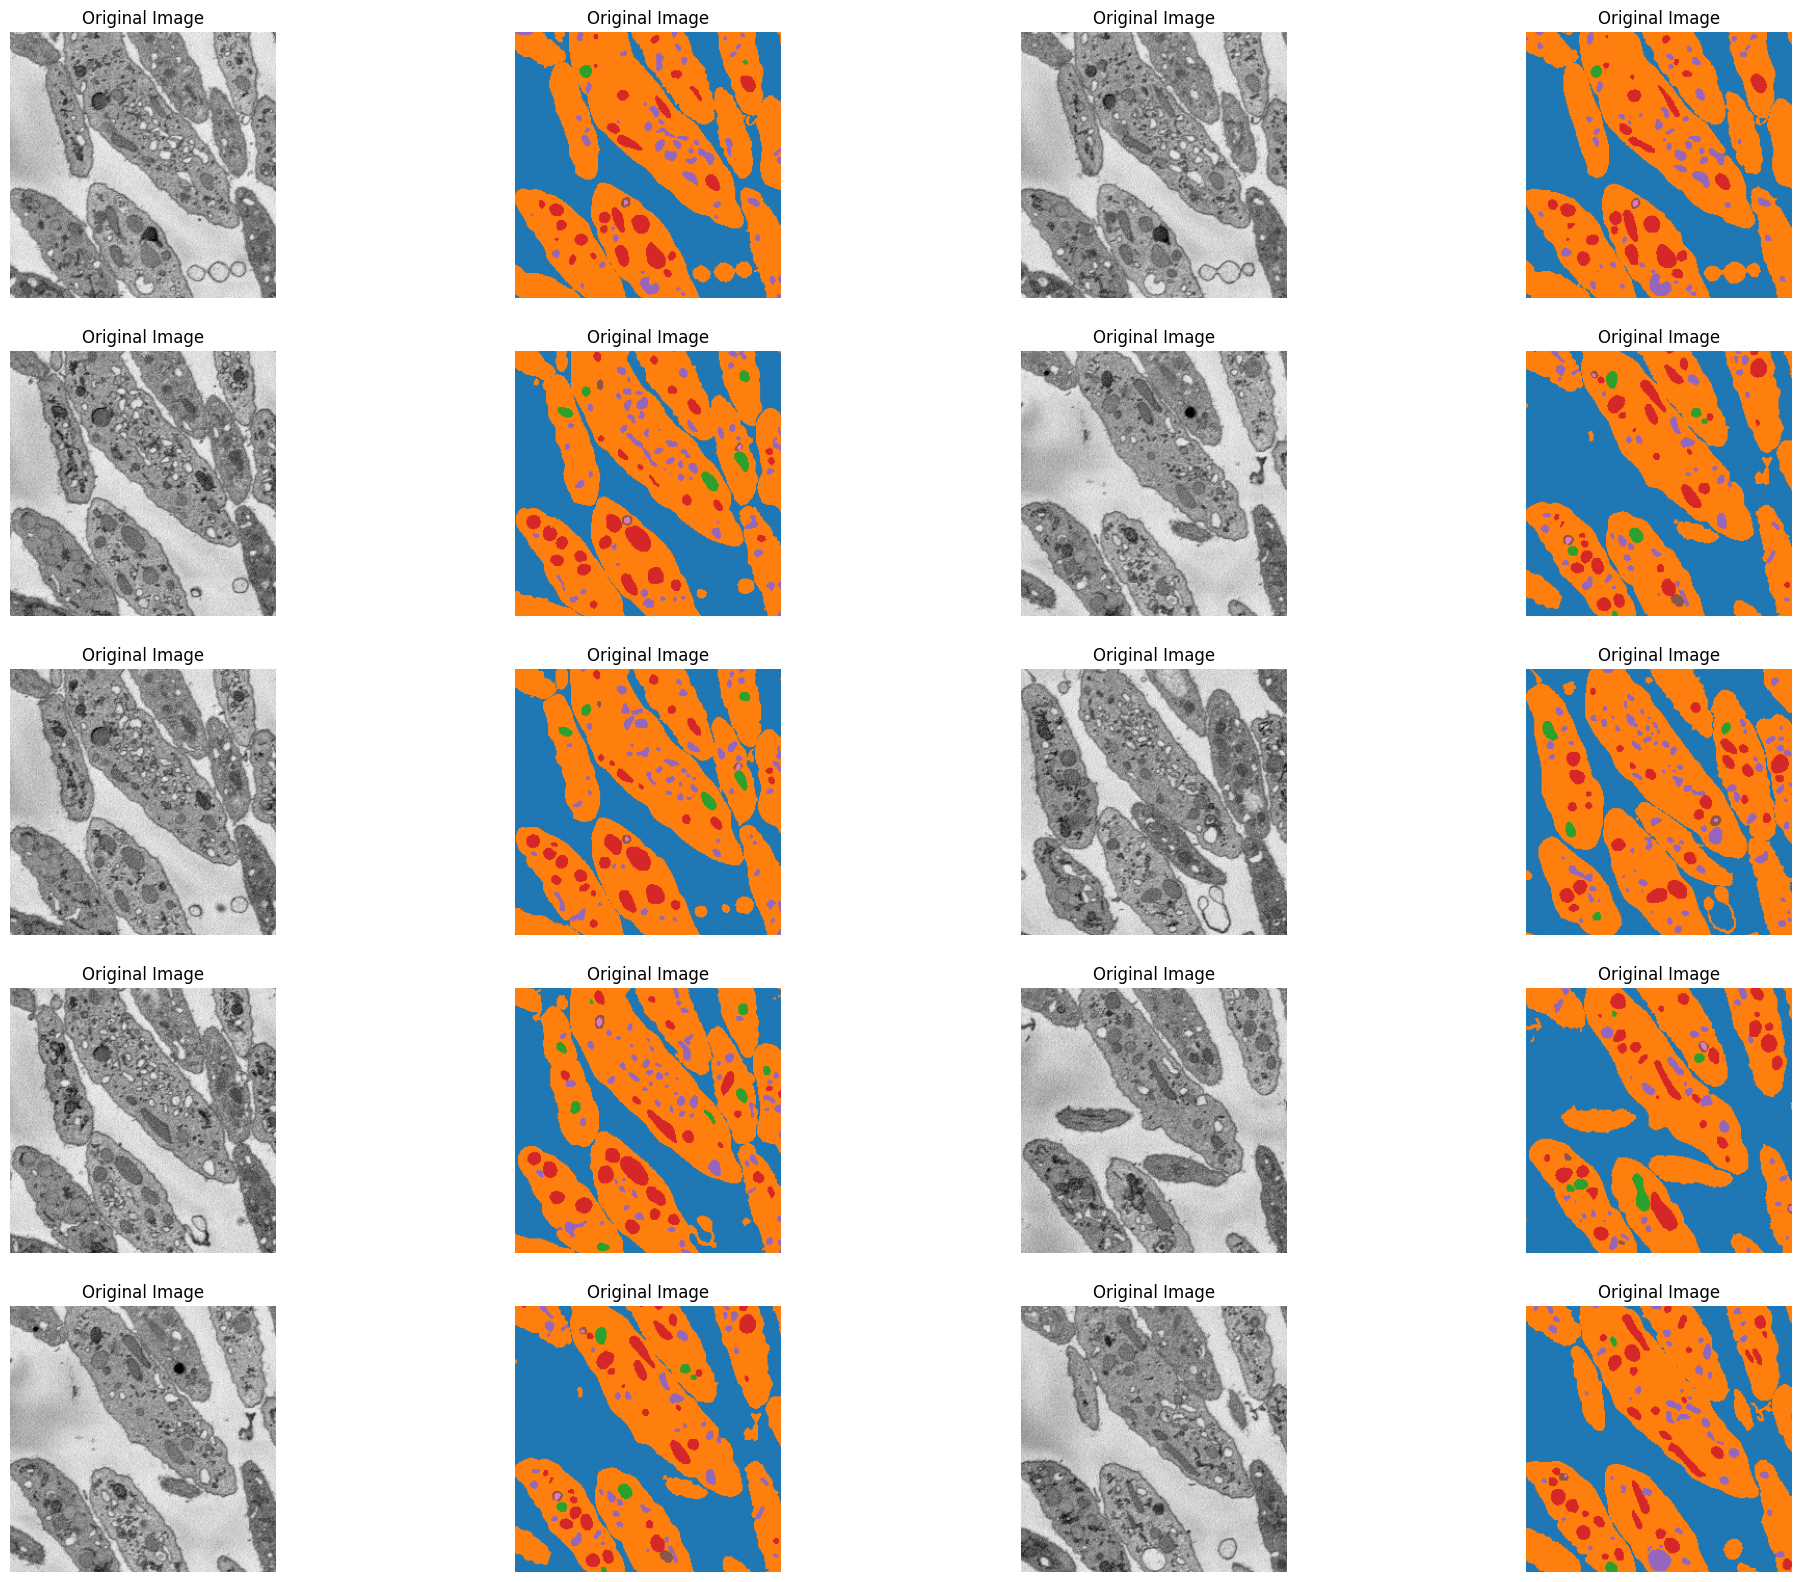

In [4]:
import random
from torchvision import transforms as tfs
import seaborn as sns

def give_color(img, n_classes):
  colors = sns.color_palette(n_colors=n_classes)
  color_mask = np.zeros((img.shape[0], img.shape[1], 3))
  for c in range(n_classes):
    c_bool = (img == c)
    color_mask[:, :, 0] += (c_bool * colors[c][0])
    color_mask[:, :, 1] += (c_bool * colors[c][1])
    color_mask[:, :, 2] += (c_bool * colors[c][2])
  return color_mask


def plot(rows, cols, count, im, gt = None, title = "Original Image"):
    
    plt.subplot(rows, cols, count)
    # plt.imshow(tn_2_np(im.squeeze(0).float()), cmap='gray') if gt else plt.imshow(tn_2_np(im.squeeze(0)), cmap='gray')
    if gt: plt.imshow(give_color(im.squeeze(0).numpy(), n_classes = 7))
    else: plt.imshow(im.squeeze(0).numpy(), cmap='gray')
    plt.axis("off"); plt.title(title)
    
    return count + 1

def visualize(ds, n_ims):
    
    plt.figure(figsize = (25, 20))
    rows = n_ims // 4; cols = n_ims // rows
    count = 1
    indices = [random.randint(0, len(ds) - 1) for _ in range(n_ims)]
    
    for idx, index in enumerate(indices):
        
        if count == n_ims + 1: break
        im, gt = ds[index]
        
        # First Plot
        count = plot(rows, cols, count, im = im)
        
        # Second Plot
        count = plot(rows, cols, count, im = gt, gt = True)
        
visualize(tr_dl.dataset, n_ims = 20)

In [6]:
print(n_cls)

7


In [7]:
#!pip3 install segmentation_models_pytorch
import segmentation_models_pytorch as smp

model = smp.DeepLabV3Plus(classes = n_cls, in_channels=1)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 3e-4)

import time
from tqdm import tqdm
from torch.nn import functional as F

class Metrics():
    
    def __init__(self, pred, gt, loss_fn, eps = 1e-10, n_cls = n_cls):
        
        self.pred, self.gt = torch.argmax(F.softmax(pred, dim=1), dim = 1), gt # (batch, width, height)
        self.loss_fn, self.eps, self.n_cls, self.pred_ = loss_fn, eps, n_cls, pred
        
    def to_contiguous(self, inp): return inp.contiguous().view(-1) 
    
    def PA(self):

        with torch.no_grad():
            match = torch.eq(self.pred, self.gt).int()
        
        return float(match.sum()) / float(match.numel())

    def mIoU(self):
        
        with torch.no_grad():
            self.gt = torch.argmax(self.gt, dim = 1)
            
            pred, gt = self.to_contiguous(self.pred), self.to_contiguous(self.gt)

            iou_per_class = []
            
            for c in range(self.n_cls):
                
                match_pred = pred == c
                match_gt   = gt == c

                if match_gt.long().sum().item() == 0: iou_per_class.append(np.nan)
                    
                else:
                    
                    intersect = torch.logical_and(match_pred, match_gt).sum().float().item()
                    union = torch.logical_or(match_pred, match_gt).sum().float().item()

                    iou = (intersect + self.eps) / (union + self.eps)
                    iou_per_class.append(iou)
                    
            return np.nanmean(iou_per_class)
    
    def loss(self): return self.loss_fn(self.pred_, torch.argmax(self.gt, dim = 1))

def tic_toc(start_time = None): return time.time() if start_time == None else time.time() - start_time

/home/acf15802az/jupyter_seg/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
def train(model, tr_dl, val_dl, loss_fn, opt, device, epochs, save_prefix, save_path = "saved_models"):
    
    tr_loss, tr_pa, tr_iou = [], [], []
    val_loss, val_pa, val_iou = [], [], []
    tr_len, val_len = len(tr_dl), len(val_dl)
    best_loss, decrease, not_improve, early_stop_threshold = np.inf, 1, 0, 7
    os.makedirs(save_path, exist_ok=True)

    model.to(device)
    train_start = tic_toc()
    print("Start training process...")
    
    for epoch in range(1, epochs + 1):
        tic = tic_toc()
        tr_loss_, tr_iou_, tr_pa_ = 0, 0, 0
        
        model.train()
        print(f"Epoch {epoch} train process is started...")
        for idx, batch in enumerate(tqdm(tr_dl)):
            
            ims, gts = batch
            ims, gts = ims.to(device), gts.to(device)
            
            preds = model(ims)
            
            met = Metrics(preds, gts, loss_fn, n_cls = n_cls)
            loss_ = met.loss()
            
            tr_iou_ += met.mIoU()
            
            tr_pa_ += met.PA()
            tr_loss_ += loss_.item()
            
            loss_.backward()
            opt.step()
            opt.zero_grad()
        
        print(f"Epoch {epoch} validation process is started...")
        model.eval()
        val_loss_, val_iou_, val_pa_ = 0, 0, 0

        with torch.no_grad():
            for idx, batch in enumerate(tqdm(val_dl)):

                ims, gts = batch
                ims, gts = ims.to(device), gts.to(device)

                preds = model(ims)

                met = Metrics(preds, gts, loss_fn, n_cls = n_cls)

                val_loss_ += met.loss().item()
                val_iou_ += met.mIoU()
                val_pa_ += met.PA()
                

        print(f"Epoch {epoch} train process is completed.")

        tr_loss_ /= tr_len
        tr_iou_ /= tr_len
        tr_pa_ /= tr_len

        val_loss_ /= val_len
        val_iou_ /=  val_len
        val_pa_ /=   val_len

        print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print(f"\nEpoch {epoch} train process results: \n")
        print(f"Train Time         -> {tic_toc(tic):.3f} secs")
        print(f"Train Loss         -> {tr_loss_:.3f}")
        print(f"Train PA           -> {tr_pa_:.3f}")
        print(f"Train IoU          -> {tr_iou_:.3f}")
        print(f"Validation Loss    -> {val_loss_:.3f}")
        print(f"Validation PA      -> {val_pa_:.3f}")
        print(f"Validation IoU     -> {val_iou_:.3f}\n")

        tr_loss.append(tr_loss_)
        tr_iou.append(tr_iou_)
        tr_pa.append(tr_pa_)

        val_loss.append(val_loss_)
        val_iou.append(val_iou_)
        val_pa.append(val_pa_)
        
        if best_loss > (val_loss_):
            print(f"Loss decreased from {best_loss:.3f} to {val_loss_:.3f}!")
            best_loss = val_loss_
            decrease += 1
            if decrease % 2 == 0:
                print("Saving the model with the best loss value...")
                torch.save(model, f"{save_path}/{save_prefix}_best_model.pt")

        if val_loss_ > best_loss:

            not_improve += 1
            best_loss = val_loss_
            print(f"Loss did not decrease for {not_improve} epoch(s)!")
            if not_improve == early_stop_threshold:
                print(f"Stopping training process becuase loss value did not decrease for {early_stop_threshold} epochs!")
                break
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
            
    print(f"Train process is completed in {(tic_toc(train_start)) / 60:.3f} minutes.")
    
    return {"tr_loss": tr_loss, "tr_iou": tr_iou, "tr_pa": tr_pa,
            "val_loss": val_loss, "val_iou": val_iou, "val_pa" : val_pa}

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [9]:
history = train(model = model, tr_dl = tr_dl, val_dl = val_dl,
                 loss_fn = loss_fn, opt = optimizer, device = device,
                 epochs = 5, save_prefix = "aerial")

Start training process...
Epoch 1 train process is started...


  0%|                                                                                                                                                                             | 0/13 [00:01<?, ?it/s]


RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[4, 1, 256, 256] to have 3 channels, but got 1 channels instead

In [ ]:
class Plot():
    
    def __init__(self, res):
        
        self.res = res
        
        self.visualize(metric1 = "tr_iou", metric2 = "val_iou", label1 = "Train IoU", 
                  label2 = "Validation IoU", title = "Mean Intersection Over Union Learning Curve", ylabel = "mIoU Score")
    
        self.visualize(metric1 = "tr_pa", metric2 = "val_pa", label1 = "Train PA", 
                  label2 = "Validation PA", title = "Pixel Accuracy Learning Curve", ylabel = "PA Score")
        
        self.visualize(metric1 = "tr_loss", metric2 = "val_loss", label1 = "Train Loss", 
                  label2 = "Validation Loss", title = "Loss Learning Curve", ylabel = "Loss Value")
        
        
    def plot(self, metric, label): plt.plot(self.res[metric], label = label)
    
    def decorate(self, ylabel, title): plt.title(title); plt.xlabel("Epochs"); plt.ylabel(ylabel); plt.legend(); plt.show()
    
    def visualize(self, metric1, metric2, label1, label2, title, ylabel):
        
        plt.figure(figsize=(10, 5))
        self.plot(metric1, label1); self.plot(metric2, label2)
        self.decorate(ylabel, title)                
        
Plot(history)

In [ ]:
def inference(dl, model, device, n_ims = 15):
    
    cols = n_ims // 3; rows = n_ims // cols
    
    count = 1
    ims, gts, preds = [], [], []
    for idx, data in enumerate(dl):
        im, gt = data

        # Get predicted mask
        with torch.no_grad(): pred = torch.argmax(model(im.to(device)), dim = 1)
        ims.append(im); gts.append(gt); preds.append(pred)
        
    plt.figure(figsize = (25, 20))
    for idx, (im, gt, pred) in enumerate(zip(ims, gts, preds)):
        if idx == cols: break
        
        # First plot
        count = plot(cols, rows, count, im)

        # Second plot
        count = plot(cols, rows, count, im = gt, gt = True, title = "Ground Truth")

        # Third plot
        count = plot(cols, rows, count, im = pred, title = "Predicted Mask")

model = torch.load("saved_models/aerial_best_model.pt")
inference(test_dl, model = model, device = device)

In [ ]:
!nvidia-smi